In [38]:
%matplotlib inline

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from detrend_func import detrend_func
from window_func import main as window_func

import dask
from distributed import Client, LocalCluster
import dask.array as da

import xarray as xr

In [39]:
# create a Dask Distributed cluster with one processor and as many
# threads as cores
cluster = LocalCluster(n_workers=1)
client = Client(cluster)

### Define constants to be used

In [40]:
dx = 5000. # meters
dy = 5000. # meters
dt = 1 # in days
H = [350.0, 750.0, 2900.0]  # meters
Htot = H[0] + H[1] + H[2]
f0 = 9.37456*(10**(-5)) #1/s (Coriolis parameter)
g = [.015, .0075]

In [41]:
tile_size = 100

#### RUN ONCE ONLY

#### ran on raijin with 32gb node. Takes about 70-80s per iteration

"""
indatadir = '/g/data1/v45/pm2987/Spunup'
outdatadir = '/g/data1/v45/jm0634/paige/Spunup_T'

for ncfile in ncfiles:
    outncfile = ncfile.replace(indatadir, outdatadir)
    outdir = os.path.dirname(outncfile)
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        
    if os.path.exists(outncfile):
        continue
        
    ds = xr.open_dataset(ncfile)\
           .isel(time=slice(None,-1)) # remove last time value since it repeated at the
                                      # start of each output file
    ds = ds.transpose('zi', 'z', 'yp', 'xp', 'time')
    
    encoding = { 'p'    : {'chunksizes': [1, 100, 100, 365]},
                 'q'    : {'chunksizes': [1, 100, 100, 365]},
                 'h'    : {'chunksizes': [1, 100, 100, 365]},
                 'taux' : {'chunksizes': [100, 100, 365]},
                 'tauy' : {'chunksizes': [100, 100, 365]},              
                 'e'    : {'chunksizes': [100, 100, 365]},
               }
    for v in encoding:
        encoding[v].update({'complevel': 0, 
                            'contiguous': False,
                            'dtype': np.dtype('float32'),
                            'source': ncfile,
                            'zlib': False})
    
    ds.to_netcdf(outncfile, engine='netcdf4', format='NETCDF4', encoding=encoding)
    del ds
"""

In [42]:
datadir = '/g/data1/v45/jm0634/paige/Spunup_T'

#ncfiles = sorted(glob(os.path.join(datadir, 'output*/ocpo.nc'))) # for all files
ncfiles = sorted(glob(os.path.join(datadir, 'output013/ocpo.nc')))

Construct a DataArray of all output files (takes a few seconds)

In [43]:
chunks = {'xp': tile_size, 'yp': tile_size, 
          'time':365, 'z':1, 'zi':1}

datasets = [xr.open_dataset(fn, 
                            chunks=chunks)
            for fn in ncfiles]

dsx = xr.concat(datasets, dim='time', coords='all')

### KE

$$
\frac{H_1}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_1}^* 
\widehat{J(\nabla_H^2 p_1,p_1)}\right]
+ \frac{H_2}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_2}^* 
\widehat{J(\nabla_H^2 p_2, p_2)}\right]
+\frac{H_3}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_3}^* 
\widehat{J(\nabla_H^2 p_3, p_3)}\right]
$$

In [63]:
def calc_KE(dsx, tile_index, z=0):
    
    # select variables
    p = dsx.p.isel(z=z)

        
    ix, iy = tile_index
    p = p.isel(yp=slice(max(iy*tile_size-3,0), (iy+1)*tile_size+3),
               xp=slice(max(ix*tile_size-3,0), (ix+1)*tile_size+3))
    xp = p.xp.values
    yp = p.yp.values
    time = p.time.values
    
    p = p.data
    p = p.rechunk(chunks={0: tile_size + 6, 1:tile_size+6})
        
    def Jacobian(p):
        # stencil
        p_cc = p
        p_ac = np.roll(p_cc,  2, axis=0)
        p_bc = np.roll(p_cc,  1, axis=0)
        p_dc = np.roll(p_cc, -1, axis=0)
        p_ec = np.roll(p_cc, -2, axis=0)
    
        p_ca = np.roll(p_cc, -2, axis=1)
        p_cb = np.roll(p_cc, -1, axis=1)
        p_cd = np.roll(p_cc,  1, axis=1)
        p_ce = np.roll(p_cc,  2, axis=1)
    
        p_bb = np.roll(p_bc, -1, axis=1)
        p_bd = np.roll(p_bc,  1, axis=1)
        p_db = np.roll(p_dc, -1, axis=1)
        p_dd = np.roll(p_dc,  1, axis=1) 
        
        p_x = p_cd - p_cb
        p_y = p_bc - p_dc
        delp_x = (p_ce + p_bd + p_dd - 4*p_cd) - (p_ca + p_bb + p_db - 4*p_cb)
        delp_y = (p_bb + p_ac + p_bd - 4*p_bc) - (p_db + p_ec + p_dd - 4*p_dc)
    
        J = delp_x*p_y - delp_y*p_x
        return J

    J = p.map_blocks(Jacobian)
    J = J[3:tile_size+3, 3:tile_size+3, :]

    # TODO: handle boundary
        
    #dx = xp[1] - xp[0]
    #dy = yp[1] - yp[1]
    # TODO: divide by gridsize^4 to get derivative
    J = 1/(dx**4)*J
    
    J = J.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    Jhat = da.fft.rfft(J, axis=2)
    Jhat = Jhat.rechunk( chunks={0: tile_size, 1:tile_size, 2: 365})

    p = p[3:tile_size+3, 3:tile_size+3, :]
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    phat = da.fft.rfft(p, axis=2)
    phat = phat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})

    KE = H[z] / (f0**3 * Htot) *(phat.conj()*Jhat).real

    KE = da.sum(KE, axis=(0,1))
    
    KE = KE.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    KE = xr.DataArray(KE, 
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return KE

In [64]:
calc_KE(dsx,(3,0))

<xarray.DataArray (freq: 183)>
array([ -5.245767e+02,  -7.954461e+00,  -2.577240e+01,  -3.118817e+00,
         2.469028e+00,  -1.324356e+01,  -3.279028e+00,  -6.309665e+00,
        -1.905063e+01,  -4.284202e+01,  -1.659338e+01,   6.610654e+00,
        -1.636314e+00,   1.008854e+00,   1.488899e+01,  -5.348409e+00,
        -9.836105e-01,  -3.776712e+00,  -1.330914e+01,  -4.049165e+00,
         3.904597e+00,  -1.635386e+00,   3.393704e-01,   2.006533e+00,
        -2.532488e+00,  -6.402928e-01,  -1.788029e-01,   6.324304e-01,
        -7.939121e-01,   1.179858e+00,   4.914009e+00,  -8.807882e-02,
        -6.815248e-01,  -6.021340e-01,   6.332996e-01,  -5.588498e-02,
        -3.481773e-01,  -1.817978e-01,  -4.960512e-01,   2.596339e-01,
         1.074930e-01,   2.206000e-01,  -8.726812e-01,   1.372742e-01,
         2.417550e-01,  -4.089107e-01,   2.996211e-01,   2.830751e+00,
         6.323234e-01,   3.277685e-01,   5.994482e-01,   7.693542e-02,
        -6.969782e-02,   6.158966e-02,   1.458

### PE


$$
\frac{1}{f_0 H_{tot}} \frac{1}{g_1'}  \mathrm{Re}  \left[ \widehat{(p_2 - p_1)}^* \widehat{J( p_1,p_2)} \right]
+ \frac{1}{f_0 H_{tot}} \frac{1}{g_2'}  \mathrm{Re}  \left[ \widehat{(p_3 - p_2)}^* \widehat{J( p_2,p_3)} \right]
$$


In [30]:
def calc_PE(dsx, tile_index, z=0):
    
    # select variables
    p1 = dsx.p.isel(z=z)
    p2 = dsx.p.isel(z=z+1)
    
    # work with DaskArrays
    ix, iy = tile_index
    p1 = p1.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    p2 = p2.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))

    
    xp = p1.xp.values
    yp = p1.yp.values
    time = p1.time.values
    
    p1 = p1.data
    p2 = p2.data 
    
    if ix==0:
        p1 = da.concatenate([p1[:,slice(0,1),:], p1], axis=1)
        p2 = da.concatenate([p2[:,slice(0,1),:], p2], axis=1)
    if iy==0:
        p1 = da.concatenate([p1[slice(0,1),:,:], p1], axis=0)
        p2 = da.concatenate([p2[slice(0,1),:,:], p2], axis=0)
    if ix==9:
        p1 = da.concatenate([p1, p1[:,slice(-1,None),:]], axis=1)
        p2 = da.concatenate([p2, p2[:,slice(-1,None),:]], axis=1)
    if iy==9:
        p1 = da.concatenate([p1, p1[slice(-1,None),:,:]], axis=0)
        p2 = da.concatenate([p2, p2[slice(-1,None),:,:]], axis=0)
        
    ny, nx, nt = p1.shape
    p1 = p1.rechunk(chunks={0: ny, 1: nx})
    p2 = p2.rechunk(chunks={0: ny, 1: nx})

    def Derivative(p, axis):
        p_right = np.roll(p, 1, axis=axis)
        p_left = np.roll(p, -1, axis=axis)
        dp = p_right - p_left
        return dp
        
    Derivative_x = lambda p: Derivative(p, 1)
    Derivative_y = lambda p: Derivative(p, 0)
    
    p1x = p1.map_blocks(Derivative_x)
    p1y = p1.map_blocks(Derivative_y)
    p2x = p2.map_blocks(Derivative_x)
    p2y = p2.map_blocks(Derivative_y)

    J = p1x*p2y - p1y*p2x
    
    J = J[1:tile_size+1, 1:tile_size+1, :]
    
    ds = da.ones(J.shape, chunks=J.chunks)*4*dx
    if ix==0:
        ds = da.concatenate( [ ds[:,slice(0,1),:]/4, ds[:,1:,:] ], axis = 1)
    if iy==0:
        ds = da.concatenate( [ ds[slice(0,1),:,:]/4, ds[1:,:,:] ], axis = 0)
    if ix==9:
        ds = da.concatenate( [ ds[:,slice(-1,None),:]/4, ds[:,:-1,:] ], axis = 1)
    if iy==9:
        ds = da.concatenate( [ ds[slice(-1, None),:,:]/4, ds[:-1,:,:] ], axis = 0)
        
    # divide needed for derivatives
    J = J / ds
    
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    J = J.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    #Jhat = da.fft.rfft(J, axis=2)
    
    pdiff = p2 - p1
    pdiff = pdiff[1:tile_size+1, 1:tile_size+1, :]
    pdiff = pdiff.rechunk(chunks={0: tile_size/10, 
                                  1: tile_size/10, 
                                  2: 365*100})
    
    # Execute fft function above
    Jhat = J.map_blocks(fft_block)
    pdiffhat = pdiff.map_blocks(fft_block)
    
    #pdiffhat = da.fft.rfft(pdiff, axis=2)
    Jhat = Jhat.rechunk( chunks={0: tile_size, 1:tile_size, 2: 365})
    pdiffhat = pdiffhat.rechunk(chunks={0: tile_size, 
                                        1: tile_size, 
                                        2: 365})
    
    PE = 1 / (f0 * Htot)*(1/g[0])*(pdiffhat.conj()*Jhat).real

    PE = da.sum(PE, axis=(0,1))
    
    PE = PE.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    PE = xr.DataArray(PE,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    return PE

calc_PE(dsx, (9,9))

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time


<xarray.DataArray (freq: 1278)>
array([ -2.613512e-06,  -1.246182e-04,  -3.080069e-05, ...,  -4.119919e-10,
        -5.252291e-10,  -2.925544e-10])
Coordinates:
  * freq     (freq) float64 0.0 0.1429 0.2858 0.4287 0.5716 0.7145 0.8574 ...
    xp       float32 4647.5
    yp       float32 4647.5

## Buoyancy

$$
\frac{1}{H_{tot}} \mathrm{Re} \left[ \widehat{(p_2 - p_1)}^* \widehat{e_1} \right]
$$


In [116]:
def calc_buoyancy(dsx, tile_index):
    # select variables
    p1 = dsx.p.isel(z=0)
    p2 = dsx.p.isel(z=1)
    e = dsx.e
    
    # work with DaskArrays
    ix, iy = tile_index
    p1 = p1.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    p2 = p2.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    e = e.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    
    xp = p1.xp.values
    yp = p1.yp.values
    time = p1.time.values
    
    p1 = p1.data
    p2 = p2.data
    e = e.data
    
    pdiff = p2 - p1
    
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)

        return varhat

    
    e = e.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    pdiff = pdiff.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    print (e)
    # Execute fft function above
    ehat = e.map_blocks(fft_block)
    pdiffhat = pdiff.map_blocks(fft_block)
    
    e = e.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    pdiff = pdiff.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    buoyancy = (1 / Htot)*(pdiffhat.conj()*ehat).real

    buoyancy = da.sum(buoyancy, axis=(0,1))
    
    buoyancy = buoyancy.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    buoyancy = xr.DataArray(buoyancy,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return buoyancy

## Windstress

$$
\frac{1}{H_{tot}} \mathrm{Re} \left[ \widehat{p_1}^* \widehat{w_{ek}} \right]
$$

In [7]:
def calc_windstress(dsx, tile_index):
    # select variables
    p = dsx.p.isel(z=0) # dimensions: (y,x,time) = (lat,lon,time)
    taux = dsx.taux
    tauy = dsx.tauy
    
# work with DaskArrays
#   - Cut 100 piece chunks, with padding on edges for derivatives
    ix, iy = tile_index
    p = p.isel(yp=slice(max(iy*tile_size,0), (iy+1)*tile_size),
                 xp=slice(max(ix*tile_size,0), (ix+1)*tile_size))
    taux = taux.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    tauy = tauy.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    
    xp = p.xp.values
    yp = p.yp.values
    time = p.time.values
    
    # Put into numpy arrays (to access the data)
    p = p.data
    taux = taux.data 
    tauy = tauy.data
    
    # Concatenate rows/columns for taking of derivative
    if ix==0:
        taux = da.concatenate([taux[:,slice(0,1),:], taux], axis=1)
        tauy = da.concatenate([tauy[:,slice(0,1),:], tauy], axis=1)
    if iy==0:
        taux = da.concatenate([taux[slice(0,1),:,:], taux], axis=0)
        tauy = da.concatenate([tauy[slice(0,1),:,:], tauy], axis=0)
    if ix==9:
        taux = da.concatenate([taux, taux[:,slice(-1,None),:]], axis=1)
        tauy = da.concatenate([tauy, tauy[:,slice(-1,None),:]], axis=1)
    if iy==9:
        taux = da.concatenate([taux, taux[slice(-1,None),:,:]], axis=0)
        tauy = da.concatenate([tauy, tauy[slice(-1,None),:,:]], axis=0)
        
    ny, nx, nt = taux.shape
    taux = taux.rechunk(chunks={0: ny, 1: nx})
    tauy = tauy.rechunk(chunks={0: ny, 1: nx})

    def Derivative(tau, axis):
        tau_right = np.roll(tau, 1, axis=axis)
        tau_left = np.roll(tau, -1, axis=axis)
        dtau = tau_right - tau_left
        return dtau
        
    Derivative_x = lambda tau: Derivative(tau, 1)
    Derivative_y = lambda tau: Derivative(tau, 0)
    
    # Run the derivative function
    tauy_x = tauy.map_blocks(Derivative_x)
    taux_y = taux.map_blocks(Derivative_y)

    # Define Ekman velocity
    wek = (1./f0) * (tauy_x - taux_y)
    
    # Trim matrix down to desired size after derivative
    wek = wek[1:tile_size+1, 1:tile_size+1, :]
    
    # If at end edges, they are less than "tile_size" long and so need to shave ends
    if len(wek[1,:,1]) < tile_size:
        wek = wek[:,:-1,:]
    if len(wek[:,1,1]) < tile_size:
        wek = wek[:-1,:,:]
    
    # Construct ds: matrix of constants to divide by in taking of derivative
    ds = da.ones(wek.shape, chunks=wek.chunks)*2*dx
    if ix==0:
        ds = da.concatenate( [ ds[:,slice(0,1),:]/2, ds[:,1:,:] ], axis = 1)
    if iy==0:
        ds = da.concatenate( [ ds[slice(0,1),:,:]/2, ds[1:,:,:] ], axis = 0)
    if ix==9:
        ds = da.concatenate( [ ds[:,slice(-1,None),:]/2, ds[:,:-1,:] ], axis = 1)
    if iy==9:
        ds = da.concatenate( [ ds[slice(-1, None),:,:]/2, ds[:-1,:,:] ], axis = 0)
        
    # Divide needed for derivatives
    wek = wek / ds
    
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat

    # Rechunk arrays into even smaller chunks for fft calculation
    wek = wek.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    
    # Execute fft function above
    wekhat = wek.map_blocks(fft_block)
    phat = p.map_blocks(fft_block)
    
    wek = wek.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    p = p.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    windstress = (1 / Htot)*(phat.conj()*wekhat).real

    windstress = da.sum(windstress, axis=(0,1))
    
    windstress = windstress.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    windstress = xr.DataArray(windstress,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return windstress

In [8]:
%%time
windstress = calc_windstress(dsx,(9,0))

Detrending in time
After time detrend  (1, 1, 1)
Making window in time
Detrending in time
After time detrend  (1, 1, 1)
Making window in time
CPU times: user 828 ms, sys: 69 ms, total: 897 ms
Wall time: 5.58 s


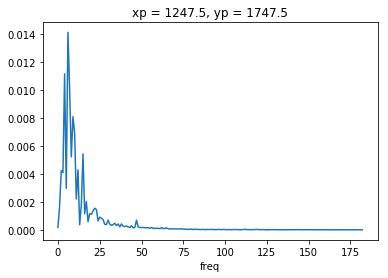

In [14]:
buoyancy.plot()

In [65]:
%%time
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range((961+tile_size+1)//(tile_size)) 
xi = range((961+tile_size+1)//(tile_size))

tile_indexes = list(product(*[yi, xi]))

KE_sum = 0
results = []
buoyancy_sum = 0
PE_sum = 0
windstress_sum = 0
for tile_index in tile_indexes[:]:
    KE1 = calc_KE(dsx, tile_index, 0)
    #KE2 = calc_KE(dsx, tile_index, 1)
    #KE3 = calc_KE(dsx, tile_index, 2)
    #KE = KE1+KE2+KE3
    
    #PE1 = calc_PE(dsx, tile_index, 0)
    #PE2 = calc_PE(dsx, tile_index, 1)
    
    #PE = PE1 + PE2
    #PE_sum += PE1
    KE_sum += KE1
    #buoyancy = calc_buoyancy(dsx, tile_index)
    
    #windstress = calc_windstress(dsx,tile_index)
    #windstress_sum += windstress
    
    #buoyancy_sum = buoyancy_sum + buoyancy
    
    # Want to sum each buoyancy term, and divide by the total number of spatial points
    #results.append(buoyancy)
    #results.sum(buoyancy)
    
    #results.append(KE)
    

    
#buoyancy_avg = buoyancy_sum/(961*961)

CPU times: user 38.8 s, sys: 3.67 s, total: 42.4 s
Wall time: 1min 36s


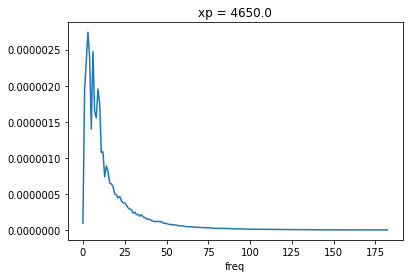

In [115]:
buoyancy_sum.plot()

In [28]:
# Define ktiso for plotting
ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.figure()
plt.plot(buoyancy_avg*ktiso)
plt.xscale('log')

NameError: name 'buoyancy_avg' is not defined

(-0.2, 0.2)

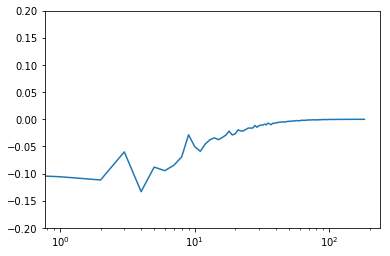

In [16]:
# Without time detrend/window

#np.save("TPE1_nodetrend_output013",PE_sum_nodetrend)

plt.figure()
plt.plot(PE_sum_nodetrend)
plt.xscale('log')
plt.ylim([-.2,.2])

(-0.2, 0.2)

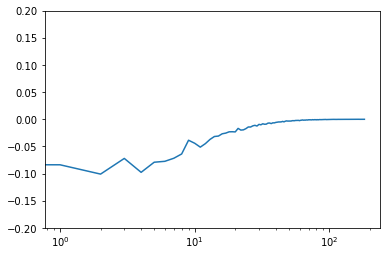

In [17]:
# With time detrend/window before FFT
#PE_sum_constantdetrend = PE_sum
#np.save("TPE1_output013",PE_sum)

plt.figure()
plt.plot(PE_sum)
plt.xscale('log')
plt.ylim([-.2,.2])

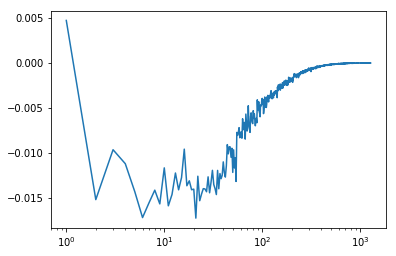

In [32]:
# With linear time detrend/window (as opposed to constant)
#PE_sum_lineardetrend = PE_sum
#np.save("TPE1_lineardetrend_output013",PE_sum_lineardetrend)

plt.figure()
plt.semilogx(PE_sum)
#plt.xscale('log')
#plt.ylim([-.2,.2])

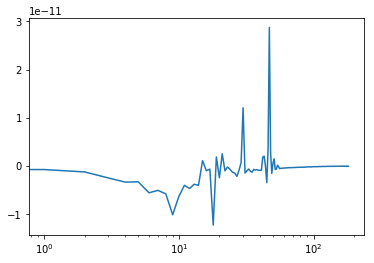

In [29]:
plt.figure()
plt.plot(windstress_sum*ktiso)
plt.xscale('log')
#windstress_sum

#windstress_sum.plot()

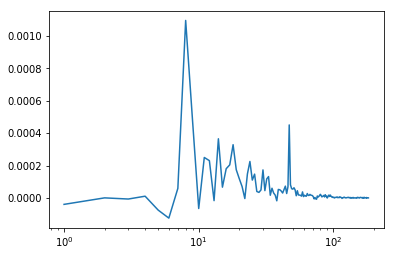

In [66]:
# Plot KE1

KE_sum_lineardetrend = KE_sum
np.save("TKE1_lineardetrend_output013",KE_sum_lineardetrend)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(KE_sum*ktiso)